In [1]:
import glob
import datetime
import numpy as np
import xarray as xr
import pandas as pd

from netCDF4 import Dataset
import matplotlib.pyplot as plt

import gsw

In [2]:
# Path to ITPs data and topography in the Canada basin file
# ITP data from https://www2.whoi.edu/site/itp/data/data-products/
path='XXX/Arctique/ITP/'
file_topo='XXX/Arctique/etopo4.mat'

In [3]:
def read_itp(file):
    """Read an ITP file and returns a xarray dataset with time and z-levels as dimensions/coordinates
    and the number of the ITP.
    """
    ds = xr.open_dataset(file,decode_times=False)
    ds = ds.assign_coords({'lon':ds['LONGITUDE'],'lat':ds['LATITUDE'],'levels':ds['BIN']})
    t0 = ds.REFERENCE_DATE_TIME.values.tolist().decode('utf-8')
    ds = ds.where(ds.JULD<700000,drop=True)
    ds = ds.assign(time=pd.to_datetime(ds.JULD.values,origin='-'.join([t0[:4],t0[4:6],t0[6:8]]),unit='D'))
    ds = ds.set_index(N_PROF='time')
    ds = ds.set_index(N_LEVELS='levels').rename({'N_PROF':'time','N_LEVELS':'levels'})
    id_itp = file.split('_')[1]

    return ds,id_itp

### Geographical area and period to study

In [4]:
# geographical zone:
lonmax=-120
lonmin=-160
latmin=65
latmax=85

# time period:
year0=2003
year1=2007
#year0=2008
#year1=2013
#year0=2014
#year1=2019

month0=1
month1=12

# depth range
p1 = 300
p2 = 700

### Selection and creation of a list of sub dataset for each itp
We stock our sub dataset in a dictionnary, list_itp, with the id of the ITPs as keys.
We read each file, select the needed time period when possible anse select the data in the good area.

In [5]:
list_itp={}
for file in glob.glob(path+'*L3*.nc'):
    ds, id_itp = read_itp(file)
    try :
        ds_sub = ds.sel(time=slice(datetime.datetime(year0,month0,1),datetime.datetime(year1,month1,30)))
    except:
        print('Ooops')
    else:
        ds_sub = ds_sub.where(np.logical_and(ds_sub.lon >= lonmin, ds_sub.lon <= lonmax),drop=True)
        ds_sub = ds_sub.where(np.logical_and(ds_sub.lat >= latmin, ds_sub.lat <= latmax),drop=True)
        if ds_sub.levels.size==0:
            pass
            #    print(file)
        else:
            if ds_sub.time.size==0:
                pass
            else:
                list_itp['%s'%str(id_itp)]= ds_sub


Ooops
Ooops
Ooops
Ooops
Ooops
Ooops


In [6]:
print('Number of ITPs : ',len(list_itp.keys()))
print('--------------------------------------')
print('Grid levels step (for each itp): ',[list_itp[itp].levels.diff(dim='levels').mean().values.tolist() for itp in list_itp])

Number of ITPs :  10
--------------------------------------
Grid levels step (for each itp):  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [7]:
# from itp
DS = {}
for itp in list_itp:
    ds = list_itp[itp]
    Lon, Lat = np.meshgrid(ds.lon.values,ds.levels.values)[0].transpose(),np.meshgrid(ds.lat.values,ds.levels.values)[0].transpose()
    SA = xr.DataArray(gsw.SA_from_SP(ds['PSAL_ADJUSTED'].values,ds['PRES_ADJUSTED'].values,Lon,Lat),dims=['time','levels'])
    CT = xr.DataArray(gsw.CT_from_t(SA,ds['TEMP_ADJUSTED'].values,ds['PRES_ADJUSTED'].values),dims=['time','levels'])
    rho = xr.DataArray(gsw.sigma0(SA,CT),dims=['time','levels'])
    DS[itp] = xr.Dataset({'SA': SA,'CT':CT,'dens':rho,'pres':ds['PRES_ADJUSTED']},
                         coords={'time':ds.time.values,'levels':ds.levels.values})

### Compute steps from ITP data

In [8]:
threshold_rho=5e-4 #threshold used for the definition of steps on the density profiles
th=10  #Minimal thickness of steps, under this value we do not count th steps

In [9]:
print('Minimal value for which we consider the gradient as the signature of a step : ',threshold_rho)
print('------------------------------------------------------------------------------')
print('Minimum thickness of steps (dbar) : ',th)

Minimal value for which we consider the gradient as the signature of a step :  0.0005
------------------------------------------------------------------------------
Minimum thickness of steps (dbar) :  10


#### Definition of density steps

In [10]:
ds_test = DS[list(list_itp.keys())[0]]
dsi = ds_test.sel(levels=slice(p1,p2))

var = dsi.dens.isel(time=114)

drho = var.differentiate('levels')
rho_th = var.where(drho>threshold_rho,drop=True)
rho_g = rho_th.where(rho_th.levels.diff(dim='levels')>th,drop=True)
rho_g = xr.concat([rho_th[np.isin(rho_th.levels.values,rho_g.levels.values)],rho_th[np.roll(np.isin(rho_th.levels.values,rho_g.levels.values),-1)]],dim='levels')
rho_g = rho_g.sortby('levels')

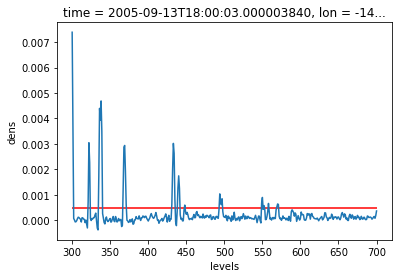

In [11]:
# density gradient and threshold
var.differentiate('levels').plot()
plt.hlines(threshold_rho,p1,p2,colors='r')

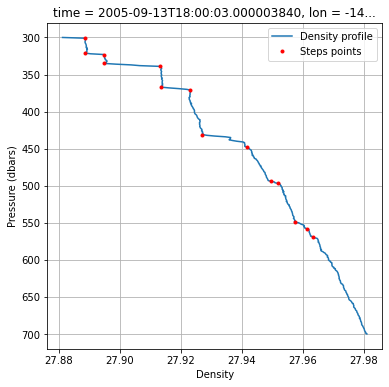

In [12]:
# steps selection
plt.figure(figsize=(6,6))
var.plot(y='levels',yincrease=False,label='Density profile')
rho_g.plot.line('r.',y='levels',yincrease=False,label='Steps points')
plt.grid();plt.ylabel('Pressure (dbars)');plt.xlabel('Density')
plt.legend()

In [13]:
# statistics : thickness, number of steps, mean thickness
nb_steps = xr.DataArray(np.array([rho_g.levels.size//2]),dims='time',coords={'time':var.time.values.reshape(1,)})
thickness = rho_g.levels.diff(dim='levels')[::2]
mean_thick = xr.DataArray(np.array([thickness.mean()]),dims='time',coords={'time':var.time.values.reshape(1,)})